**Проект 3 "Дашборд конверсий"**

**Шаг 1-3**

Задачи:
1. Сделать запросы по API и получить данные по визитам и регистрациям.
2. Взять последний визит у посетителя.
3. Избавиться от ботов в таблице с визитами.
4. Объединить таблицы визитов и регистраций.

In [5]:
# импортируем библиотеки
import os
from dotenv import load_dotenv
import requests
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import dash
from dash import dcc
from dash import html

In [ ]:
# Загрузка переменных из окружения
load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

In [6]:
# получаем данные визитов и регистраций по API
visits = requests.get('https://data-charts-api.hexlet.app/visits?begin=2023-03-01&end=2023-09-01')
visits_json = visits.json()

regs = requests.get('https://data-charts-api.hexlet.app/registrations?begin=2023-03-01&end=2023-09-01')
regs_json = regs.json()

In [7]:
# преобразовываем в таблицы
df_vis = pd.DataFrame(visits_json)
df_regs = pd.DataFrame(regs_json)

In [8]:
# избавляемся от времени в колонках 'datetime'
df_vis['date_group'] = pd.to_datetime(df_vis['datetime'])
df_vis['date_group'] = df_vis['date_group'].dt.date

df_regs['date_group'] = pd.to_datetime(df_regs['datetime'])
df_regs['date_group'] = df_regs['date_group'].dt.date

In [9]:
# удаляем ботов в визитах
df_vis = df_vis[~df_vis['user_agent'].str.contains('bot')]

In [10]:
# берем последний визит,группируем и считаем таблицу с визитами
visits_clean = df_vis.loc[df_vis.groupby('visit_id')['datetime'].idxmax()]
visits = visits_clean.groupby(['date_group', 'platform'])['visit_id'].agg('count')

In [11]:
# группируем и считаем таблицу с регистрациями
regs_itog = df_regs.groupby(['date_group', 'platform'])['user_id'].agg('count')

In [12]:
# объединяем визиты и регистрации
merged_df = pd.merge(visits, regs_itog, left_index=True, right_index=True, how='outer')

In [13]:
# переименовываем колонки
merged_df = merged_df.rename(columns={'visit_id': 'visits', 'user_id': 'registrations'})

In [14]:
# считаем конверсию
merged_df['conversion'] = round(merged_df['registrations']*100 / merged_df['visits'], 2)
merged_df = merged_df.reset_index()
merged_df

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.33
1,2023-03-01,ios,22,18,81.82
2,2023-03-01,web,279,8,2.87
3,2023-03-02,android,67,59,88.06
4,2023-03-02,ios,31,24,77.42
...,...,...,...,...,...
547,2023-08-30,ios,66,40,60.61
548,2023-08-30,web,1227,34,2.77
549,2023-08-31,android,57,42,73.68
550,2023-08-31,ios,50,36,72.00


In [15]:
# сохраняем итоги
merged_df.to_json('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/conversion.json')

**Шаг 4**

Задачи:
1. Прочитать файл с данными о рекламных кампаниях.
2. Присоединить таблицу с рекламой к данным по регистрациям и визитам.

In [18]:
# читаем таблицу с рекламой, избавляемся от времени
ads_df = pd.read_csv('ads.csv')
ads_df['date'] = pd.to_datetime(ads_df['date'])
ads_df['date'] = ads_df['date'].dt.date
ads_df.head()

,date,utm_source,utm_medium,utm_campaign,cost
0,2023-03-01,google,cpc,advanced_algorithms_series,212
1,2023-03-02,google,cpc,advanced_algorithms_series,252
2,2023-03-03,google,cpc,advanced_algorithms_series,202
3,2023-03-04,google,cpc,advanced_algorithms_series,223
4,2023-03-05,google,cpc,advanced_algorithms_series,265


In [19]:
# соединяем таблицу конверсий и данные по рекламе
data = pd.merge(merged_df, ads_df, left_on='date_group', right_on='date', how='inner')
# Заполним пустые значения 0 для cost и none для utm_campaign
data['cost'].fillna(0)
data['utm_campaign'].fillna('None')
# выбираем необходимые столбцы
data = data[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]
data

,date_group,visits,registrations,cost,utm_campaign
0,2023-03-01,75,61,212,advanced_algorithms_series
1,2023-03-01,22,18,212,advanced_algorithms_series
2,2023-03-01,279,8,212,advanced_algorithms_series
3,2023-03-02,67,59,252,advanced_algorithms_series
4,2023-03-02,31,24,252,advanced_algorithms_series
...,...,...,...,...,...
421,2023-08-30,66,40,109,intro_to_python_course
422,2023-08-30,1227,34,109,intro_to_python_course
423,2023-08-31,57,42,215,intro_to_python_course
424,2023-08-31,50,36,215,intro_to_python_course


In [20]:
data.to_json('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/ads.json')

**Шаг 5**

Задачи: построить следующие графики в формате PNG:
1. Итоговые визиты
2. Итоговые визиты с разбивкой по платформам: web, android, ios
3. Итоговые регистрации
4. Итоговые регистрации с разбивкой по платформе: web, android, ios
5. Конверсия по каждой платформе
6. Средняя конверсия
7. Стоимости реклам
8. Визиты за весь период с цветовым выделением рекламной кампании
9. Регистрации за весь период с цветовым выделением рекламной кампании

In [35]:
# Создание директории для графиков
if not os.path.exists('charts'):
    os.makedirs('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/charts')

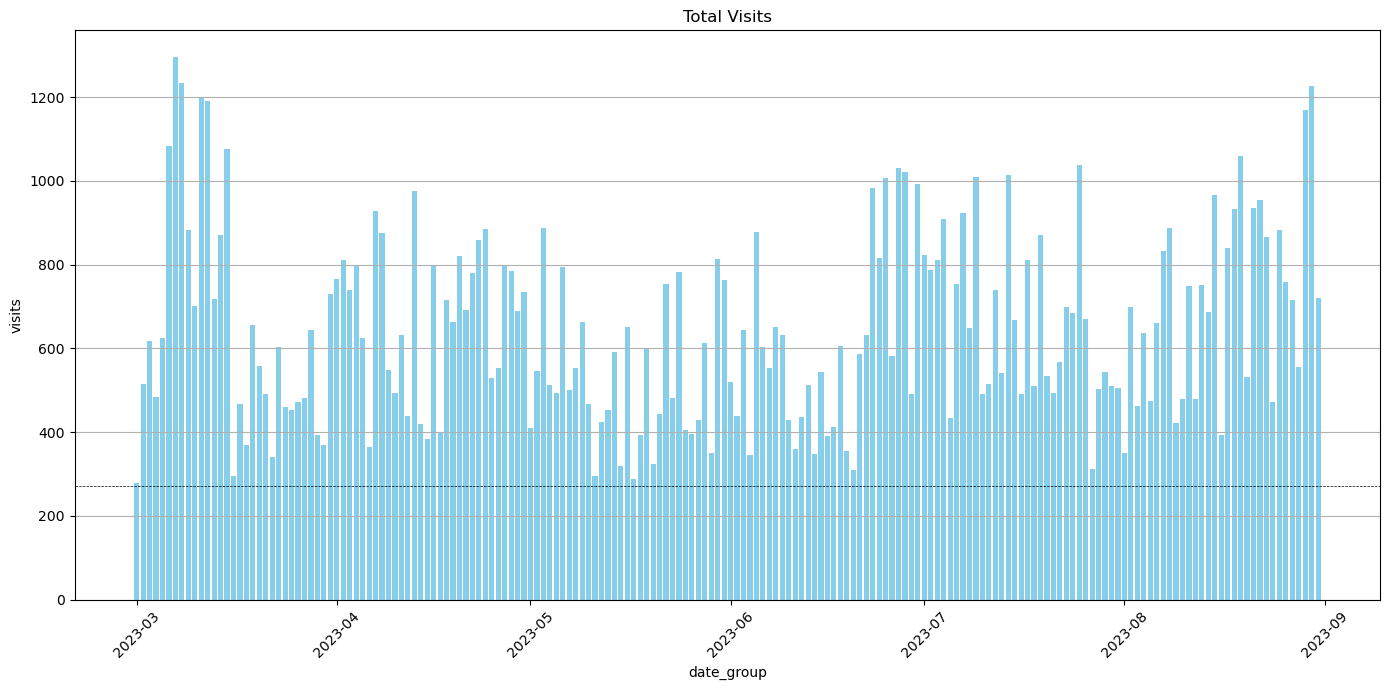

In [82]:
# итоговые визиты
plt.figure(figsize=(14, 7))
bars = plt.bar(merged_df['date_group'], merged_df['visits'], color='skyblue')
plt.xlabel('date_group')
plt.ylabel('visits')
plt.title('Total Visits')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.axhline(data['visits'].mean(),  color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/charts/total visits.png')

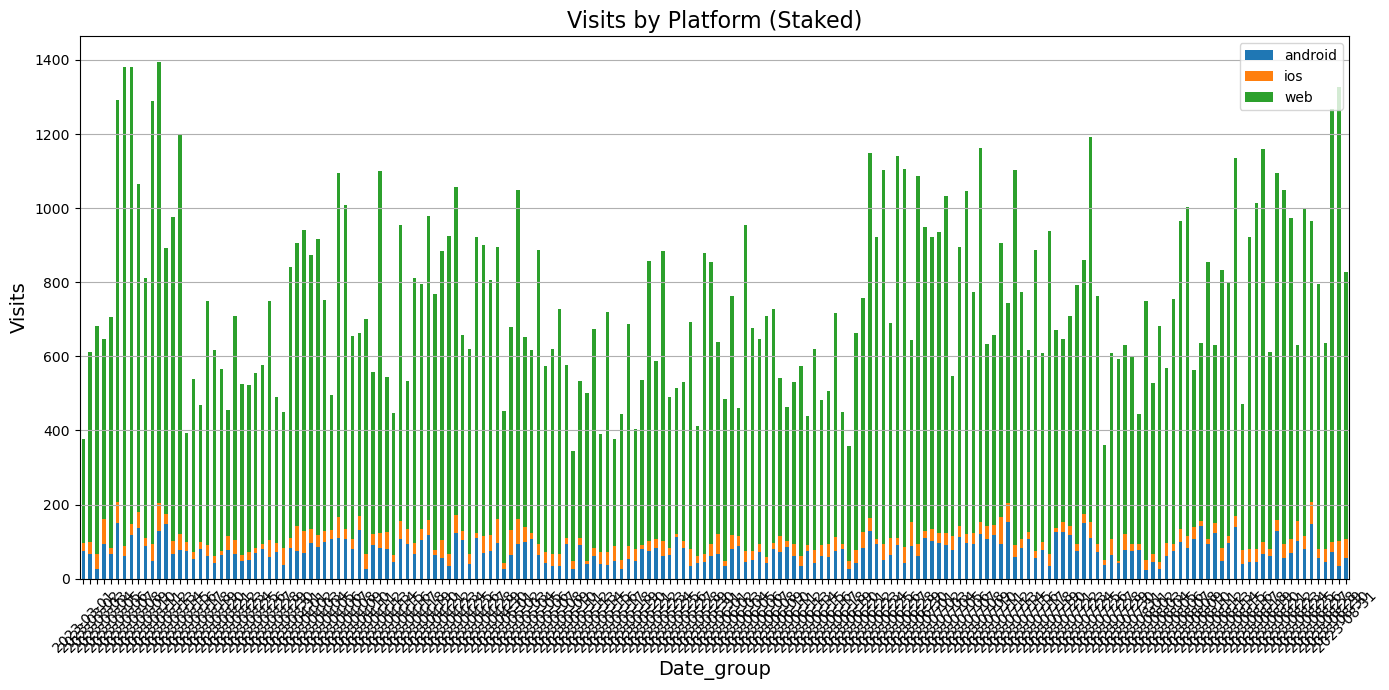

In [39]:
# итоговые визиты с разбивкой по платформам
def total_visits_pltfm_chart(df):
    fig, ax = plt.subplots(figsize=(14,7))
    df = merged_df.pivot_table(index='date_group', columns='platform', values='visits')
    df.plot(kind='bar', stacked=True, ax=ax)
    plt.title('Visits by Platform (Staked)', fontsize=16)
    plt.xlabel('Date_group',fontsize=14)
    plt.ylabel('Visits',fontsize=14)
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/charts/visits by platforms.png')
    plt.show()

total_visits_pltfm_chart(data)

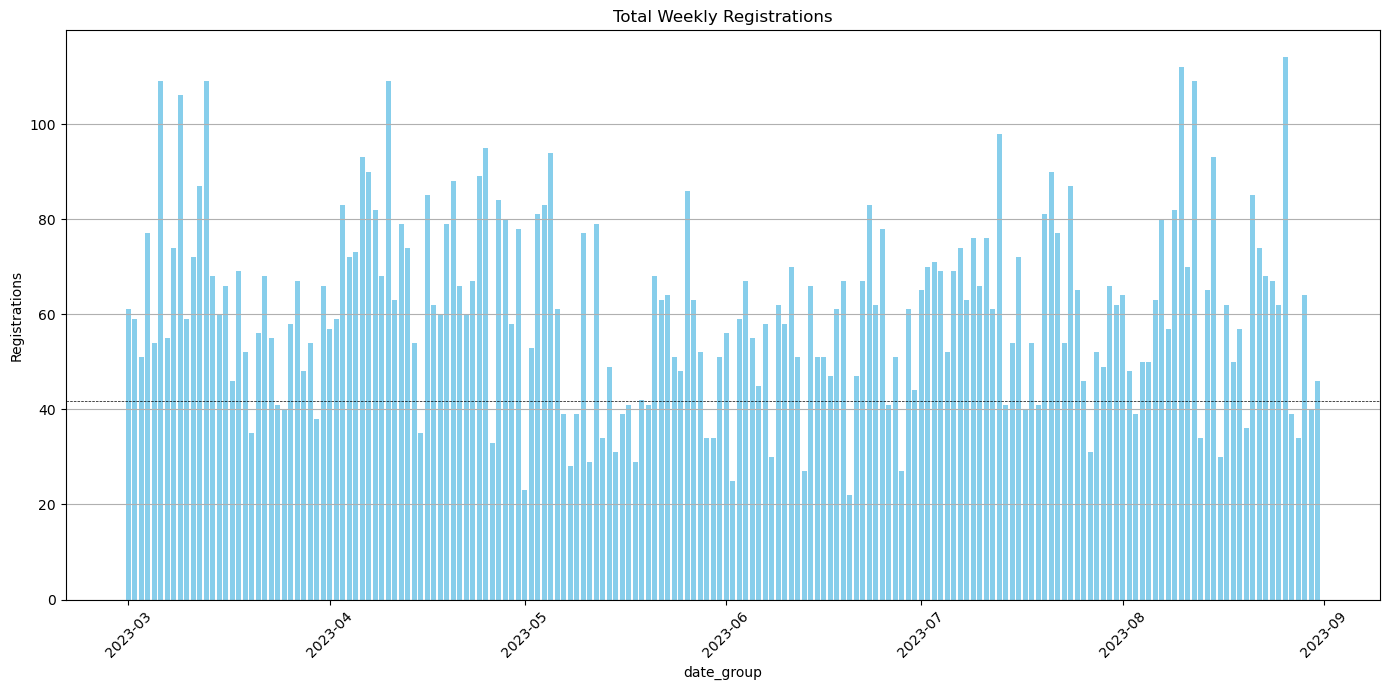

In [84]:
# итоговые регистрации
plt.figure(figsize=(14, 7))
bars = plt.bar(merged_df['date_group'], merged_df['registrations'], color='skyblue')
plt.xlabel('date_group')
plt.ylabel('Registrations')
plt.title('Total Weekly Registrations')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.axhline(data['registrations'].mean(),  color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/charts/total registrations.png')

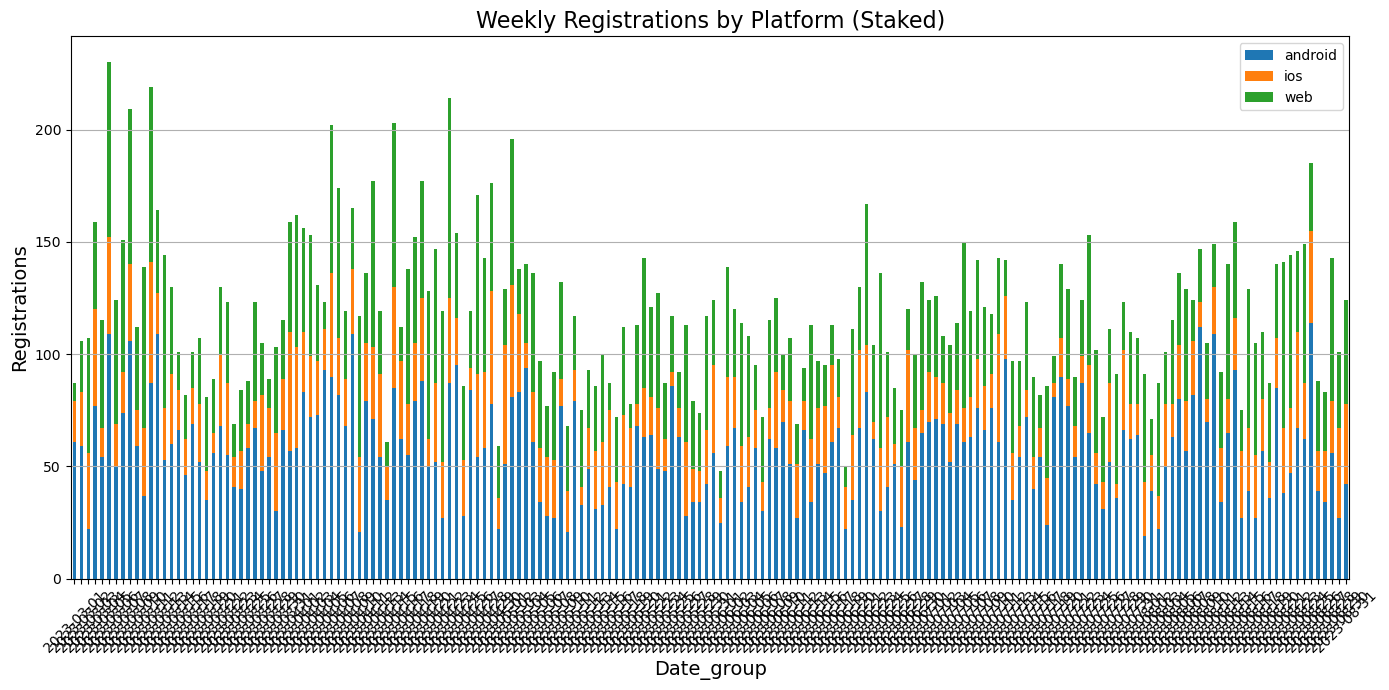

In [43]:
# итоговые регистрации с разбивкой по платформам
def total_visits_pltfm_chart(df):
    fig, ax = plt.subplots(figsize=(14,7))
    df = merged_df.pivot_table(index='date_group', columns='platform', values='registrations')
    df.plot(kind='bar', stacked=True, ax=ax)
    plt.title('Weekly Registrations by Platform (Staked)', fontsize=16)
    plt.xlabel('Date_group',fontsize=14)
    plt.ylabel('Registrations',fontsize=14)
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/charts/regs by platforms.png')
    plt.show()

total_visits_pltfm_chart(data)

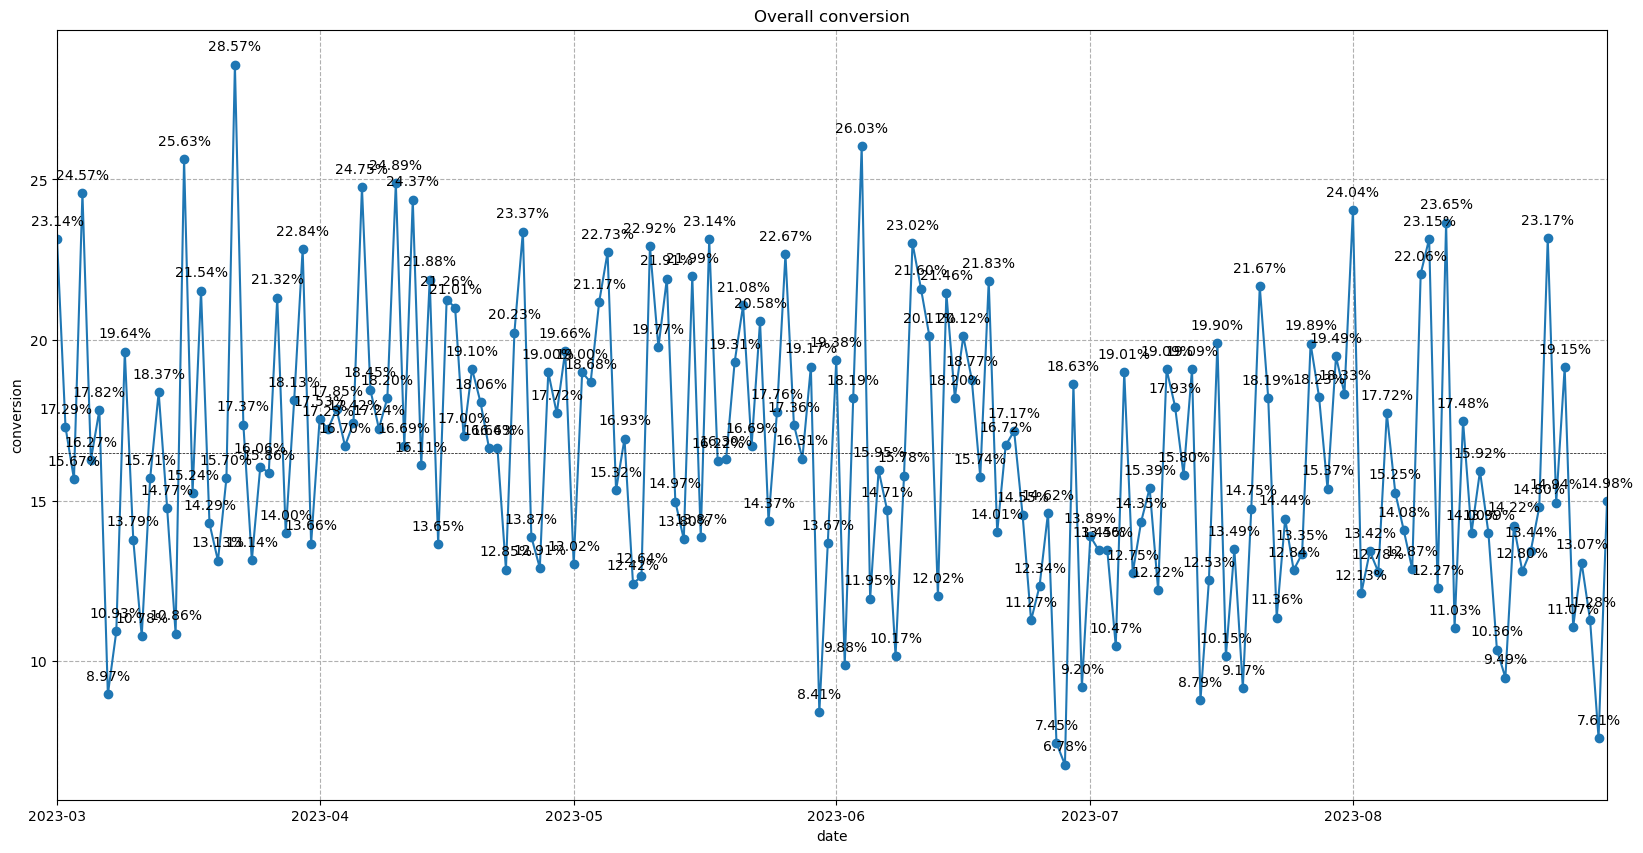

In [90]:
conversion_df = merged_df.groupby(['date_group']).agg({'visits': 'sum', 'registrations': 'sum'})
conversion_df['conversion'] = round(conversion_df['registrations'] / conversion_df['visits'] * 100, 2)
conversion_df = conversion_df.reset_index()

x = conversion_df['date_group']
y = conversion_df['conversion']

fig, ax = plt.subplots(figsize=(20, 10))

conversion_plot = ax.plot(x, y, marker='o')

for x, y in zip(x, y):

    label = '{:.2f}%'.format(y)

    ax.annotate(label, 
                 (x, y),
                 textcoords='offset points',
                 xytext=(0,10),
                 ha='center')

ax.set_title('Overall conversion')
ax.set_xlabel('date')
ax.set_ylabel('conversion')
ax.margins(x=0)
ax.grid(True, linestyle='dashed')
plt.axhline(conversion_df['conversion'].mean(),  color='black', linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)
plt.savefig('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/charts/conversion by campaign.png')

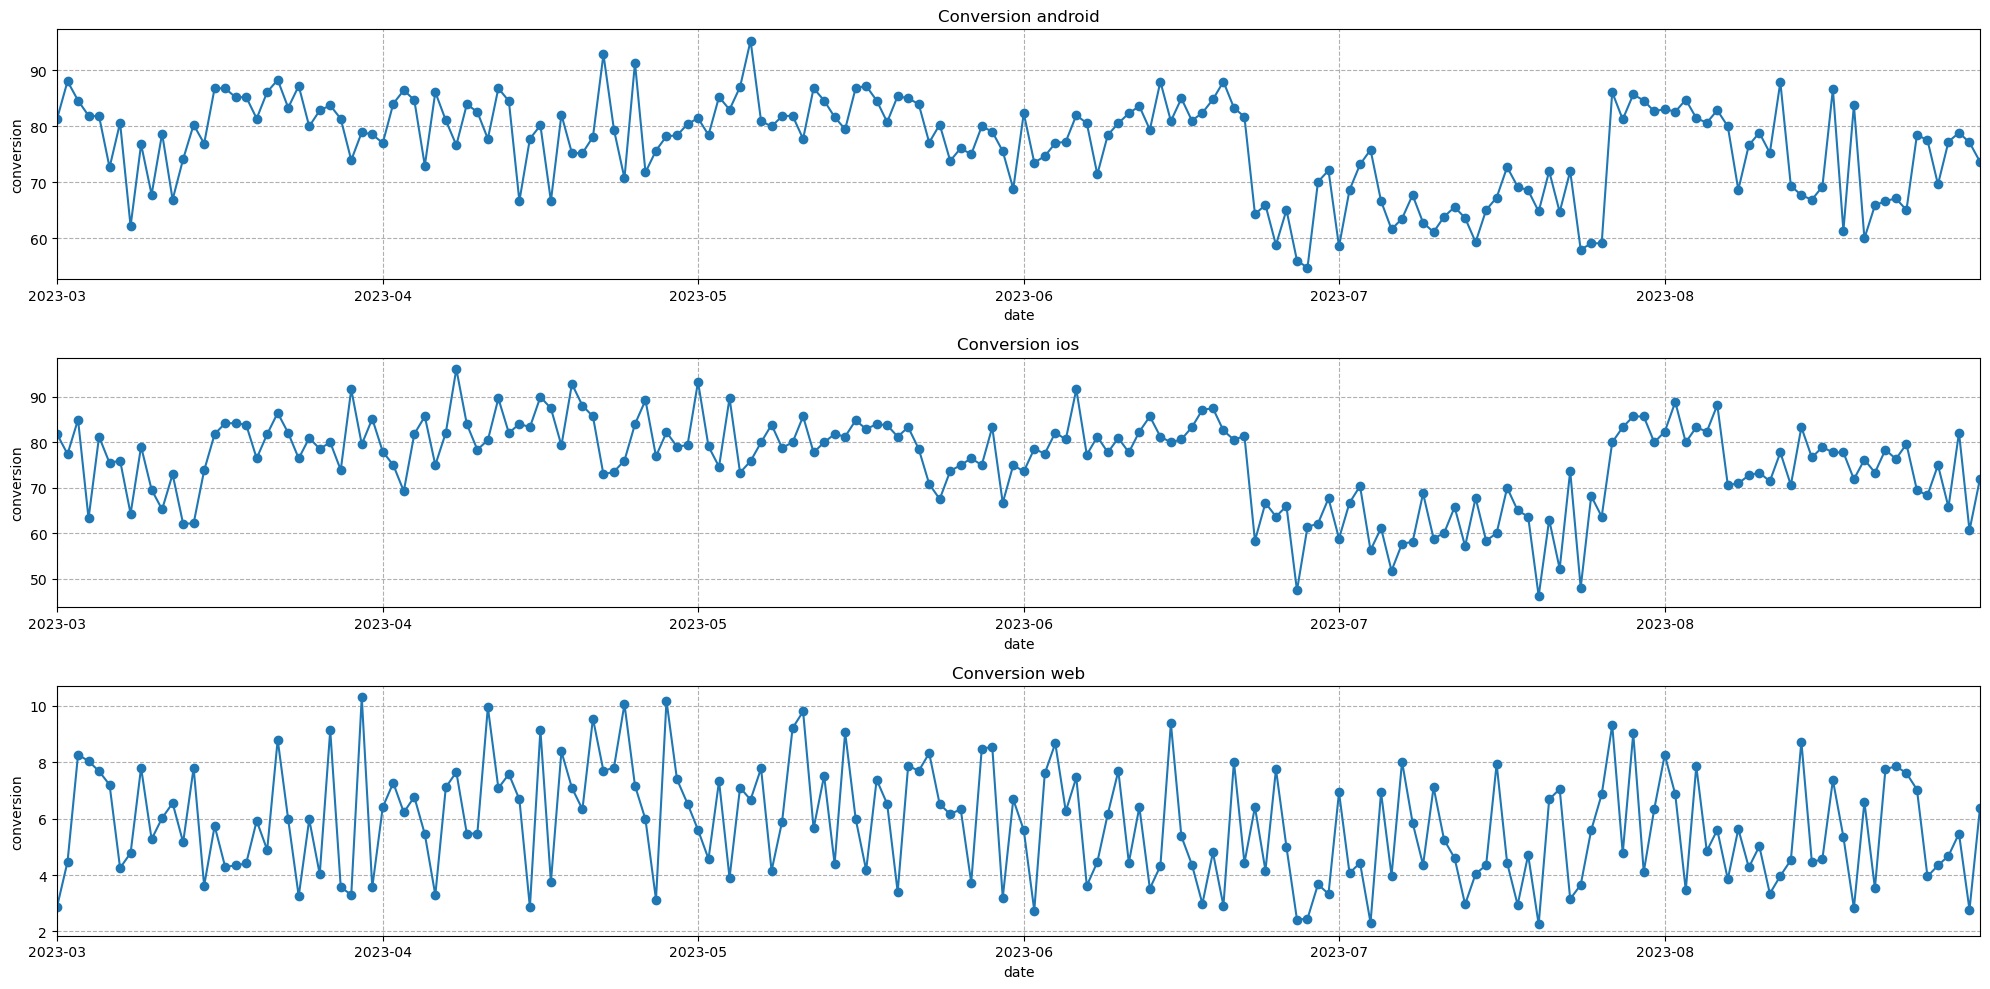

In [57]:
# Конверсия по каждой платформе
android_df = merged_df.loc[merged_df['platform'] == 'android'].groupby(['date_group']).agg({'visits': 'sum', 'registrations': 'sum'})
android_df['conversion'] = round(android_df['registrations'] / android_df['visits'] * 100, 2)
android_df = android_df.reset_index()

ios_df = merged_df.loc[merged_df['platform'] == 'ios'].groupby(['date_group']).agg({'visits': 'sum', 'registrations': 'sum'})
ios_df['conversion'] = round(ios_df['registrations'] / ios_df['visits'] * 100, 2)
ios_df = ios_df.reset_index()

web_df = merged_df.loc[merged_df['platform'] == 'web']
web_df = web_df.groupby(['date_group']).agg({'visits': 'sum', 'registrations': 'sum'})
web_df['conversion'] = round(web_df['registrations'] / web_df['visits'] * 100, 2)
web_df = web_df.reset_index()

x = android_df['date_group']
y_1 = android_df['conversion']
y_2 = ios_df['conversion']
y_3 = web_df['conversion']

fig, ax = plt.subplots(figsize=(20, 10), nrows=3, ncols=1, layout='tight')

ax[0].set_title('Conversion android')
ax[0].plot(x, y_1, marker='o')
ax[0].set_xlabel('date')
ax[0].set_ylabel('conversion')
ax[0].grid(True)
ax[0].margins(x=0)
ax[0].grid(True, linestyle='dashed')
ax[0].set_axisbelow(True)

ax[1].set_title('Conversion ios')
ax[1].plot(x, y_2, marker='o')
ax[1].set_xlabel('date')
ax[1].set_ylabel('conversion')
ax[1].grid(True)
ax[1].margins(x=0)
ax[1].grid(True, linestyle='dashed')
ax[1].set_axisbelow(True)

ax[2].set_title('Conversion web')
ax[2].plot(x, y_3, marker='o')
ax[2].set_xlabel('date')
ax[2].set_ylabel('conversion')
ax[2].grid(True)
ax[2].margins(x=0)
ax[2].grid(True, linestyle='dashed')
ax[2].set_axisbelow(True)

plt.savefig('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/charts/conversion by pltf.png')
plt.show()

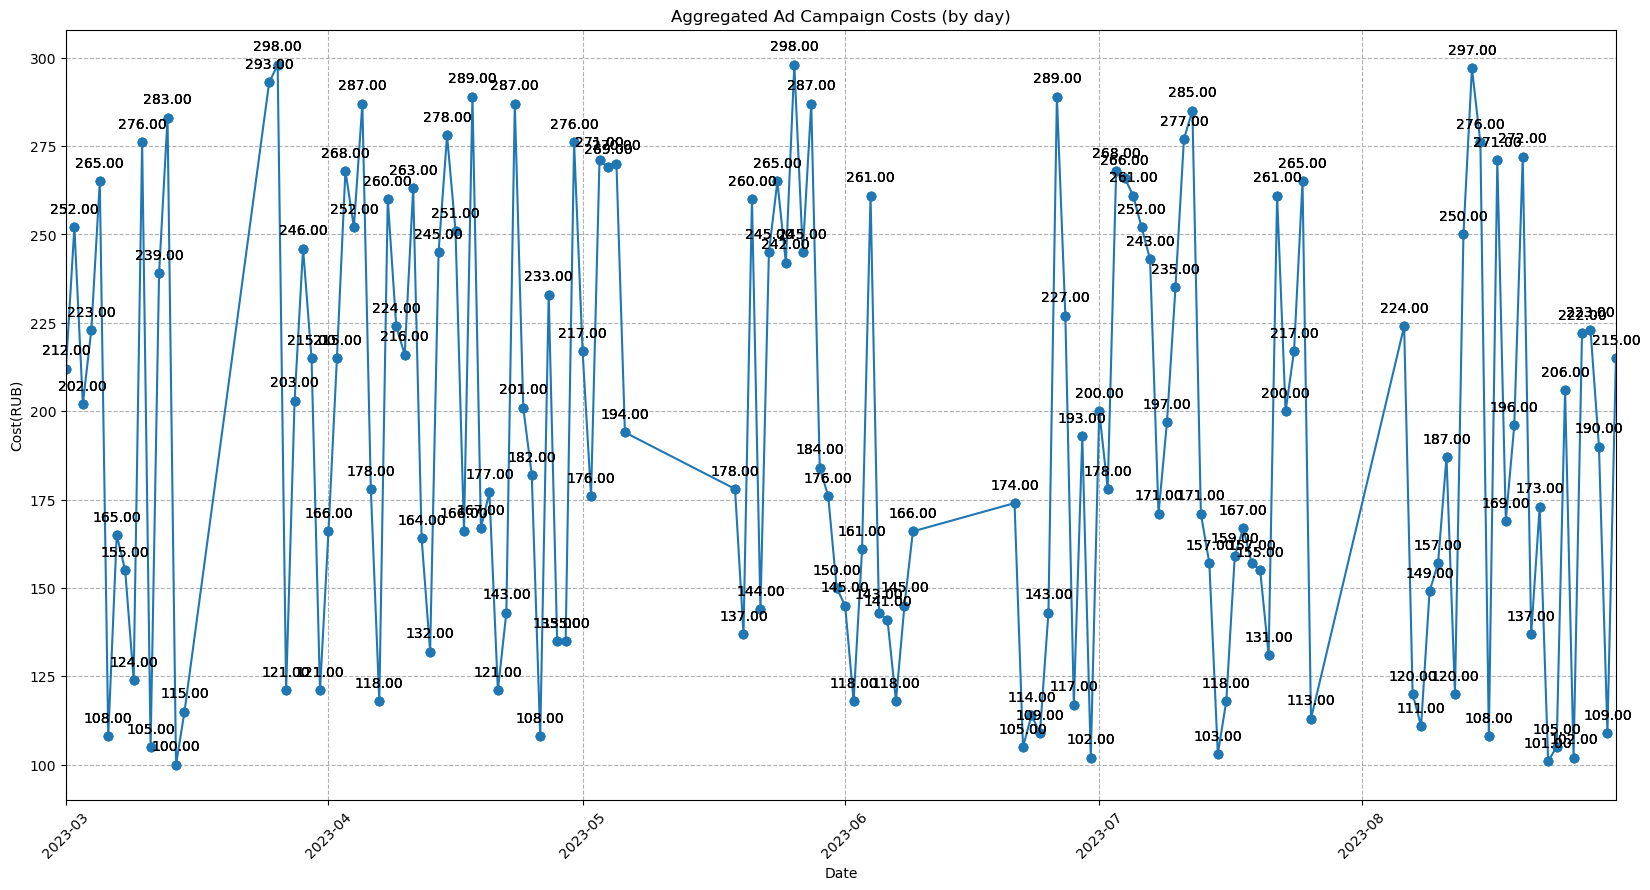

In [59]:
# стоимость реклам
x = data['date_group']
y = data['cost']

fig, ax = plt.subplots(figsize=(20, 10))

total_cost_plot = ax.plot(x, y, marker='o')

for x, y in zip(x, y):

    label = '{:.2f}'.format(y)

    ax.annotate(label, 
                 (x, y),
                 textcoords='offset points',
                 xytext=(0,10),
                 ha='center')

ax.set_title('Aggregated Ad Campaign Costs (by day)')
ax.set_xlabel('Date')
ax.set_ylabel('Cost(RUB)')
ax.margins(x=0)
plt.xticks(rotation = 45)
ax.grid(True, linestyle='dashed')
ax.set_axisbelow(True)
plt.savefig('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/charts/agg by platforms.png')
plt.show()

In [63]:
# находим дату начала и дату окончания рекламной кампании
charts = data.groupby('utm_campaign')['date_group'].agg(['min', 'max']).reset_index()
charts.sort_values(by='min')

,utm_campaign,min,max
0,advanced_algorithms_series,2023-03-01,2023-03-15
3,virtual_reality_workshop,2023-03-25,2023-05-06
2,ui_ux_design_drive,2023-05-19,2023-06-09
4,women_in_tech_symposium,2023-06-21,2023-07-26
1,intro_to_python_course,2023-08-06,2023-08-31


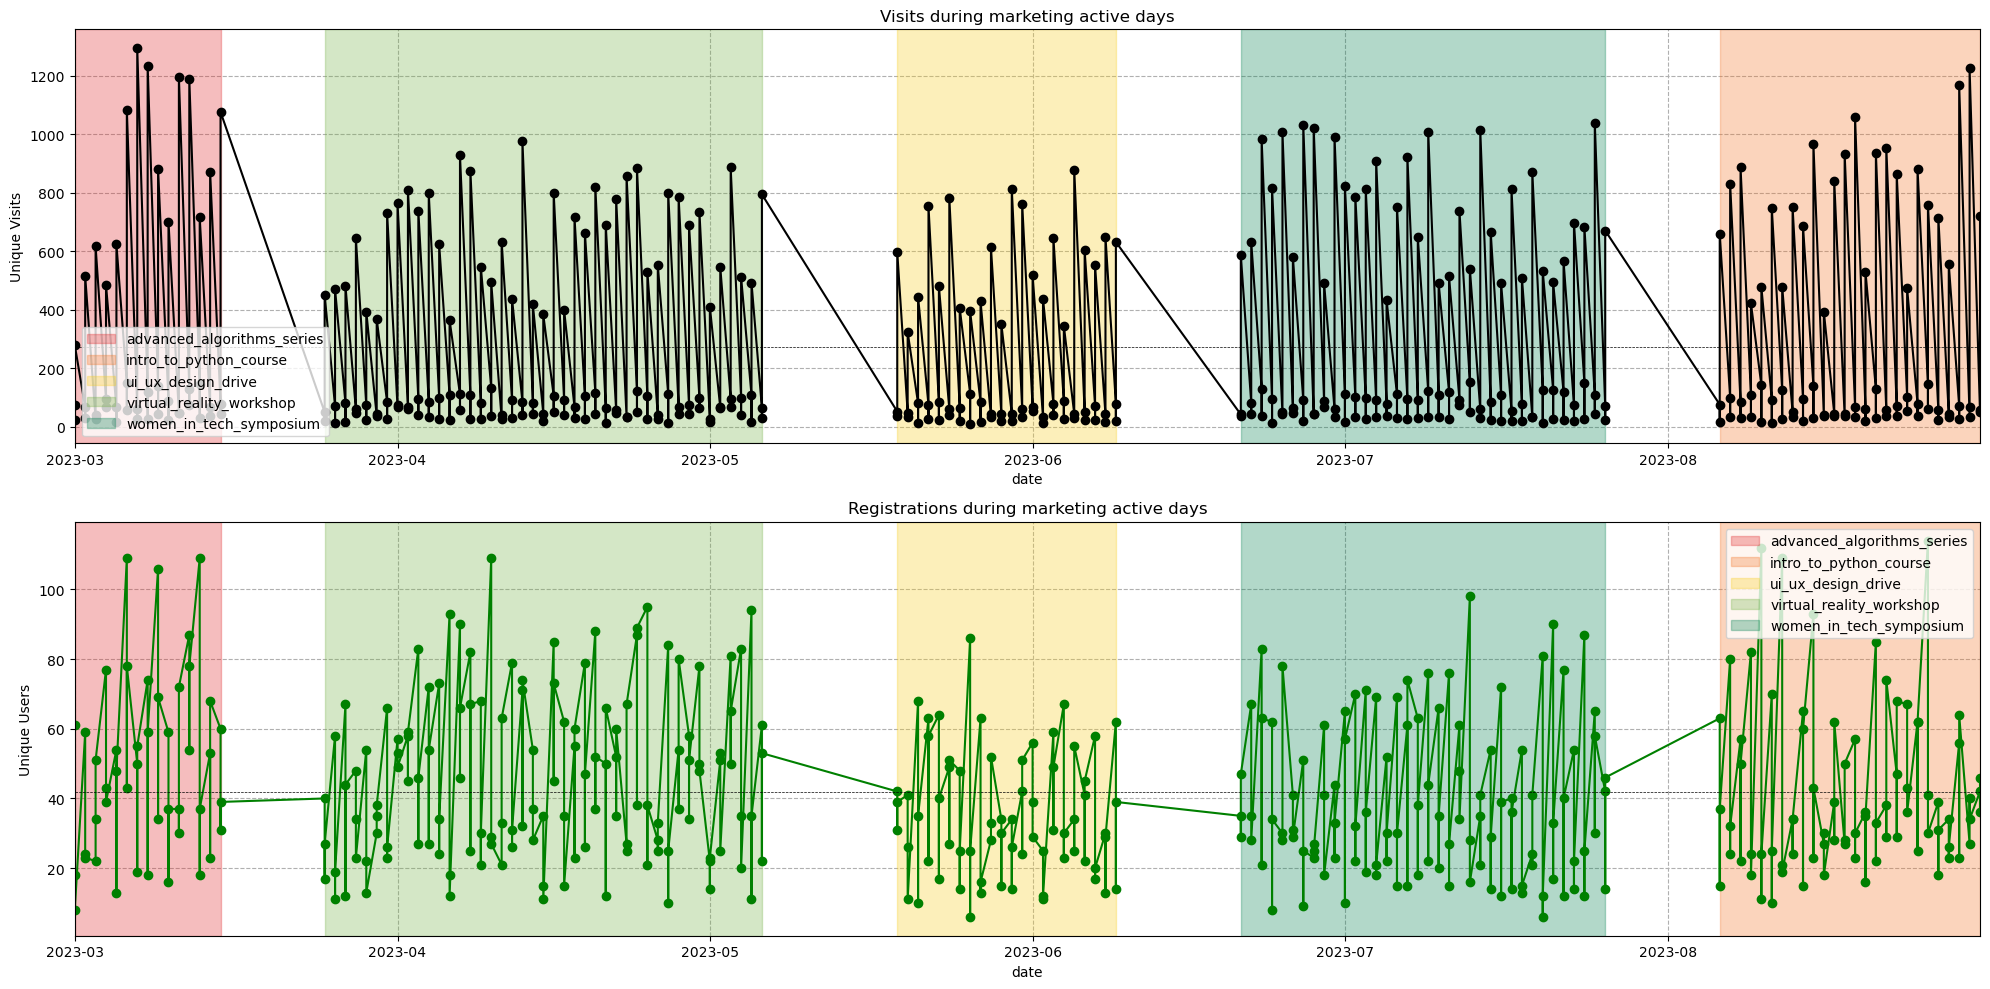

In [71]:
# визиты и регистрации с выделением рекламных кампаний 
x = data['date_group']
y_1 = data['visits']
y_2 = data['registrations']

color_palette = [
    '#e12729',
    '#f37324',
    '#f8cc1b',
    '#72b043',
    '#007f4e'
]

count_1 = 0
count_2 = 0

fig, ax = plt.subplots(figsize=(20, 10), nrows=2, ncols=1, layout='tight')

for id, row in charts.iterrows():
    x0 = row['min']
    x1 = row['max']
    annotation_text = row['utm_campaign']
    color=color_palette[count_1]
    count_1 += 1
    ax[0].axvspan(x0, x1, color=color, alpha = 0.3, label = annotation_text)

ax[0].plot(x, y_1, marker='o', color='black')
ax[0].set_title('Visits during marketing active days')
ax[0].set_xlabel('date')
ax[0].set_ylabel('Unique Visits')
ax[0].margins(x=0)
ax[0].grid(True, linestyle='dashed')
ax[0].set_axisbelow(True)
ax[0].legend(loc='lower left')
ax[0].axhline(data['visits'].mean(),  color='black', linestyle='--', linewidth=0.5)

for id, row in charts.iterrows():
    x0 = row['min']
    x1 = row['max']
    annotation_text = row['utm_campaign']
    color=color_palette[count_2]
    count_2 += 1
    ax[1].axvspan(x0, x1, color=color, alpha = 0.3, label = annotation_text)

ax[1].plot(x, y_2, marker='o', color='green')
ax[1].set_title('Registrations during marketing active days')
ax[1].set_xlabel('date')
ax[1].set_ylabel('Unique Users')
ax[1].margins(x=0)
ax[1].grid(True, linestyle='dashed')
ax[1].set_axisbelow(True)
ax[1].legend(loc='upper right')
ax[1].axhline(data['registrations'].mean(),  color='black', linestyle='--', linewidth=0.5)

plt.savefig('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/charts/vis regs by campaign.png')

plt.show()